<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

# Week 3 - Convolutional neural networks
(*Material also available p. 287 - 321 in Bishop*)

Convolutional Neural Networks (CNN's) are the most common application of convolutions. Here, the weights bewteen neurons usually learned in a fully connected neural network are replaced by kernels, which are learned instead.

At the end of this week, you should be able to:

- Explain how padding works to perserve image dimensions during convolution

---

CNN's are most commonly used today for three distinct purposes:

1. Image classification: The amount of parameters in a CNN is effectively *invariant* with regards to the size of the input image. Additionally, CNN's basically learn to do feature extraction to find important parts of an image in much the same way regular convolution does.
2. Signal analysis: Much like when dealing with images, the number of parameters in a CNN does not scale with the length of a signal used for input. Also again, convolving a signal is basically the same as applying a filter, which can be used to extract useful features. This makes CNN's important for cases such as denoising or classifying signals of varying length.
3. Noise prediction in diffusion models: Probably the most "modern" application, a variant of CNN's, a "U-net" is used for many diffusion models that serve to generate for example images.

Like every other class of neural network out there, CNN's have a million-and-one specific
methods and ideas to improve their performance, in these exercises, we only really explain pooling. Also, there are a billion-and-two different specific architectures (like the aforementioned "U-net"), that are useful in specific or different cases. For this course, we will only examine a specific implementaiton of "basic" CNN: VGG16-D. Even so, understanding the fundamentals of convolutional layers, you should be able to grasp the basics of most other implementation of CNN that exists.

---

**Remember to ask questions as much as you need, includin the "stupid" ones. CNN's, perhaps more than most other subjects, has tons of "I really should understand this, but I don't, therefore I must be dumb"-moments. Don't sweat it if it seems trivial, *it probably isn't*!**

---

Many of these exercises, will require writing and changing some PyTorch syntax. This is not required material for the exam, but is pretty much necessary to learn at some point. Don't get stuck on the specifics of syntax you don't understand, but at the same time, don't completely neglect learning this syntax! 

</span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms.functional
from torchvision.transforms import ToTensor
import PIL.Image
from tqdm import tqdm
import os

# Finally, a useful function that we do not explicitly use, but you can check out if you want
# from torchsummary import summary # courtesy of https://stackoverflow.com/questions/55875279/how-to-get-an-output-dimension-for-each-layer-of-the-neural-network-in-pytorch


<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">


## Part 1 - Manual calculations for CNN

These intitial exercises will focus on the parameters and dimensionality of input and output in CNN's. If at any point you feel confident in these, you can skip to **part 2** for details on how to implement a CNN?

</span>

<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 1 - Parameters in learnable kernels

For this exercise, we consider a kernel in a convolutional layer with the following parameters:

- Size: $3 \times 3$
- Padding (zero-padded): $1$
- Stride: $1$
- Input channels: $3$

#### **1.1. How many learnable parameters does this kernel have in a CNN?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

This has one parameter per value in the kernel, including one bias term. The kernel is technically size $3 \times 3 \times 3$ since there are $3$ inputs channels. 

$$3\cdot3\cdot3 + 1 = 28 \text{ learnable parameters}$$

Note here: You can kinda argue about whether or not the bias term should be included in this... I decided to do it since the question says 'in a CNN', but you could leave it out and still get the right answer I would argue.

</span>

#### **1.2. In general, how many parameters does an 𝑛 \times m kernel with d input channels, 𝑝 padding and 𝑠 stride have?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Neither the stride nor the padding actually influences the amount of parameters. So we have

$$ \text{num learnable parameters} = n \cdot m \cdot d + 1 $$

</span>

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 2 - Parameters in conolutional layers


Say you now have a convolutional layer with the following hyperparameters:

- Kernel size: $n \times m$
- Input channels: $d$
- Output channels: $k$


#### **2.1: How many learnable parameters does this whole convolutional layer have?**


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Here, we  multiply our result from 1.1 with how many output channels we have, since a convolutional layer is essentially just k kernels, each applied to all input channels.

$$\text{num learnable parameters} = (n \cdot m \cdot d + 1) \cdot k$$


</span>

#### **2.2. 💻 Check your manual calculation against that of the torch implementation below**


In [2]:
# Parameters for a toy convolutional layer
in_channels = 3
out_channels = 128
kernel_size = (2,3) # Does not have to be a tuple, if int, will be converted to a square kernel
stride = 1
padding = 0
bias = True

# Define conv layer and sum number of parameters
conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=True)
num_params = sum(p.numel() for p in conv_layer.parameters())

# Calculate number of parameters manually
num_params_manual = ((in_channels*kernel_size[0]*kernel_size[1] + bias)*out_channels) # ANSWER: (d * m * n + 1) * k

print(f"Torch thinks there are {num_params} parameters in the layer layer \nCompared to {num_params_manual} calculated manually")

Torch thinks there are 2432 parameters in the layer layer 
Compared to 2432 calculated manually


<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 3 - Dimensions after convolutional layers


We are now given a convolutional layer with the following hyperparameters:
- Size: $n \times n$
- Padding: $p$
- Stride: $s$
- Input channels: $d$
- Output channels: $k$

And an input image with dimensions $N\times N \times d$, so a square image with $d$ channels


#### **3.1. What is the dimensionality of the output image after passing through the given convolutional layer?**


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

One go-to source is the [torch documentation for conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html):

$$N_{out} = \left\lfloor{\frac{N + 2\cdot p - (n - 1) - 1}{s} + 1}\right\rfloor$$

Number of input channels do not have any effect on number of output channels, only number of output channels do. So we get dimensionality

$$(N_{out}, N_{out}, k)$$


</span>

#### **3.2. Likewise, what is the dimensionality after a *pooling* layer with the same parameters as the convolutional layer?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

The absolute same, only this time we cannot exactly define a number of 'output channels', so the output dim is just

$$(N_{out}, N_{out}, d)$$

I.E the input dimension = output dimension

</span>


#### **3.3. 💻 Check your answer against the torch code below**


</span>



In [3]:
# Once more, Parameters for a simple convolutional layer
in_channels = 3
out_channels = 128
kernel_size = (2,3) # Does not have to be a tuple, if int, will be converted to a square kernel
stride = 1
padding = 0
bias = True

# Define conv layer and sum number of parameters
conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=True)

# Define two dimensional max pooling layer
max_pool_layer = nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=padding)

# Load image and convert to tensor
a_cool_image = PIL.Image.open("images/a_cool_image.jpg").convert("RGB")
# Unsqueeze to add batch dimension (because torch is nasty like that and expects a batch dimension)
a_cool_image_tensor = torchvision.transforms.functional.to_tensor(a_cool_image).unsqueeze(0)

print(f"Image shape before convolution: {a_cool_image_tensor.shape}")

# Apply convolution and max pooling
convolved_image = conv_layer(a_cool_image_tensor)
pooled_image = max_pool_layer(a_cool_image_tensor)

print(f"Image shape after convolution: {convolved_image.shape}")
print(f"Image shape after max pooling: {pooled_image.shape}")

Image shape before convolution: torch.Size([1, 3, 56, 56])
Image shape after convolution: torch.Size([1, 128, 55, 54])
Image shape after max pooling: torch.Size([1, 3, 55, 54])


<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 4 - Benefits of channels


It should be clear now, that each channel in the output image, corresponds to one kernel
being run across all channels in the input image. 

Therefore with $k$ output channels, we have to train $k$ kernels, each with $m \times n \times d + 1$ parameters.


#### **4.1. Discuss some of the benefits of having a larger number of output channels compared to input channels.**


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Each output channel is another kernel with its own set of learnable parameters. Thus, each extra output channel is one more set of potential features we can capture to the next layer. We can reason from this that images with few complicated-to-extract features will require few kernels but many layers, and images with many easy-to-extract features will require many kernels but few layers.

This is of course mostly conjecture, the correct answer will vary from situation to situation

</span>

#### **4.2. Increasing the number of output channels in one layer obviously leads to more kernels (and therefore more parameters), but how does this increased number of output channels affect the kernels in subsequent layers in a neural network?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Worse than you'd think (maybe). Each extra dimension going out of a layer is an extra dimension that will need to go into the next layer **for each kernel**. Therefore, if we raise the output dimension from one layer to another layer with a $n \times n$ kernel and $k$ output channels, not only do we increase the number of parameters for the layer going into the other layer, each of the $d$ kernels in the incoming layer will need another $n \times n$ parameters to account for the greater number of input channels.

</span>

</span>



<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 5 - (Not) Flipping the kernel

If you read the torch documentation of [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), you won’t find anywhere that it flips the kernel as is otherwise required to go from cross-correlation to convolution.

**5.1. Explain how PyTorch, a respectable deep learning framework, can get away with *not*
flipping the kernel**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

The weights in the kernel of a CNN are entirely learned, so even *if* the ML gods required a flipped kernel to make convolutions work at all, the network could just learn a flipped kernel instead.

</span>


<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

## Part 2 - Coding CNN's

Theres a **bunch** of boilerplate that goes into every NN implementation in Python. Our advice, is to understand and solve the exercises given first, and then look into this boilerplate.

A lot of people and guides tell you to simply ignore this boilerplate code, and you can... **But it will haunt you later**

</span>

<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

### 1. Import packages, check cuda availability, and seed everything

</span>

In [4]:
# Check if you have cuda available, and use if you do
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Set a random seed for everything important
def seed_everything(seed: int):
    import random
    import os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = False

# Set a seed with a random integer, in this case, I choose my verymost favourite sequence of numbers
seed_everything(sum([115, 107, 105, 98, 105, 100, 105, 32, 116, 111, 105, 108, 101, 116]))


cuda


<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

### 2. Download and define either [Cifar10]() or Mnist as dataset

We are going to use the [cifar10](https://www.cs.toronto.edu/~kriz/cifar.html), that is a bunch of images of 10 different classes. cifar100 with 100 classes also exists, but models for that would be a bit too large for this course...

</span>

In [5]:
# Load a dataset, change 'dataset' to 'cifar10' if you want to use CIFAR-10 instead
dataset = 'cifar10'

if dataset == 'cifar10':
    train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
    test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=ToTensor())

    # Purely for our convenience - Mapping from cifar labels to human readable classes
    cifar10_classes = {
        0: 'airplane',
        1: 'automobile',
        2: 'bird',
        3: 'cat',
        4: 'deer',
        5: 'dog',
        6: 'frog',
        7: 'horse',
        8: 'ship',
        9: 'truck'
    }

elif dataset == 'mnist':
    train_set = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
    test_set = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

print(f"There are {len(train_set)} examples in the training set")
print(f"There are {len(test_set)} examples in the test set \n")

print(f"Image shape is: {train_set[0][0].shape}, label example is {train_set[0][1]}")

There are 50000 examples in the training set
There are 10000 examples in the test set 

Image shape is: torch.Size([3, 32, 32]), label example is 6


<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

### 3. Define collate function and dataloaders

Dataloders are not *necessary* per say, but are very useful. 

A dataloader is a torch utility that functions like an *iterator*, that is, we can loop over it where it gives batches of data and labels. The number of data points in each batch is defined by the *batch_size*. *Shuffle ensures we shuffle the ordering of images so the model does not get any inherent information from the ordering of data. 

The collate function controls how each batch is transformed before being given when we iterate over the dataloader. In this case, we simple just the *default_collate* (which we normally don't need to specify), but also cast each tensor to our chosen device, either CUDA or CPU.

</span>

In [6]:
# Collate function is called on each batch, the dataloader yields
# Here, we modify it to also cast the tensor to our desired device
from torch.utils.data.dataloader import default_collate
def collate_fn(batch):
    return tuple(x_.to(device) for x_ in default_collate(batch))

# Why don't we shuffle the test set? Because we don't need to.
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False, collate_fn=None)

<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

### 4. Show a few examples from the dataset

As is tradition when making CNN introductions

The quality is pretty terrible. You can reason a bit about why...

</span>

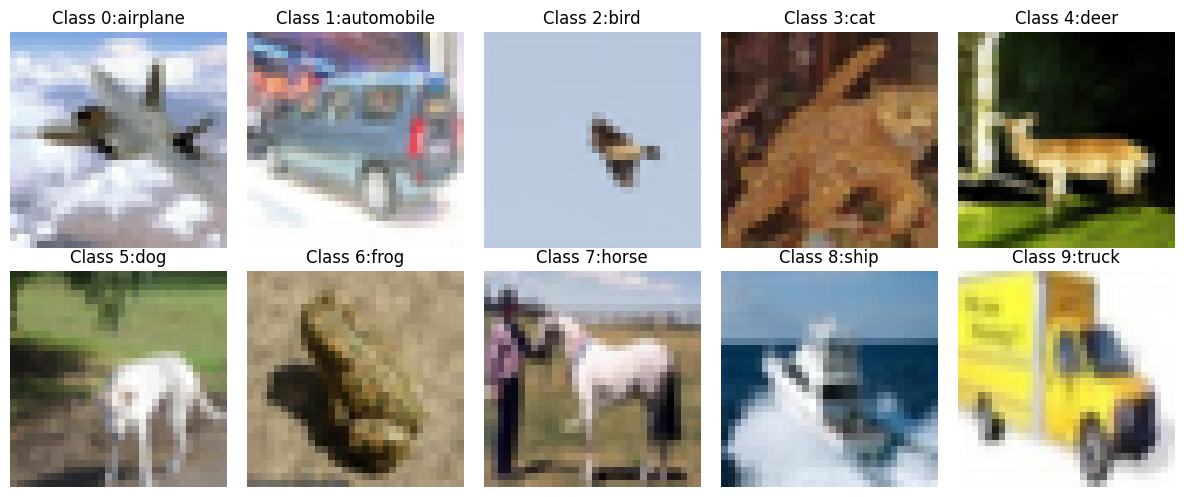

In [7]:
# Get indices of 10 different classes in the dataset, then get values
sampled_indices = [np.random.choice(np.where(np.array(train_set.targets) == i)[0]) for i in range(10)]
examples = train_set.data[sampled_indices]

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

# Plot examples
for i in range(len(examples)):
    img = examples[i]
    if dataset == 'mnist':
        img = img.squeeze(0)  # Remove the channel dimension for MNIST
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Class {i}')
    else:
        axes[i].imshow(img)
        axes[i].set_title(f'Class {i}:{cifar10_classes[train_set.targets[sampled_indices[i]]]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

### Define a CNN class

We have now reached the point, where we can define the main class that'll compose our CNN.

Keep in mind the following:
- The amount of parameters in a convolutional layer is $(n * m * l + 1) * k$  
   - Where $n, m$ is the kernel size $(x, y)$, $l$ is the input channels, and $k$ is the $\text{output channels} + 1$, is beacuse of a bias term that is done for each input
  - Basically, $n * m * l$ corresponds to kernels mapping to values in another "image"
  - Each kernel has a bias term unique to it. Each kernel produces one "image", that are then stacked on top of each other, for a total of $k$ images.
  - CONV2D does NOT flip the kernel!!!
    - But, it doesn't really mattter, since it is just learned anyways...

Finally, we found an answer on if it is better to ReLU first or Max Pool first... it *mostly* doesn't matter
- [But it is slightly better to maxpool first, max-pooling and monotonely increasing non-linearities commute. This means that MaxPool(Relu(x)) = Relu(MaxPool(x)) for any input](https://stackoverflow.com/questions/35543428/activation-function-after-pooling-layer-or-convolutional-layer
)

</span>

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### $\star$ Exercise 5: Coding the CNN

As the star indicates, this is an optional exercise. You are encouraged to search online, ask you friends, LLM, or the TA's on tips or best practices to implement a working CNN. This part is optional because it *is* mostly coding, but it is recommended, as it will probably help to know *how* to do it, both genrally, and with the first assignment.

#### **💻 5.1. Complete the layers for the CNN class. There are a few ways you *could* go about doing this:**

**1. Do it with a [torch.nn.sequential](https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html) object, ala what they do [here](https://docs.pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html). The pros here are that it may be easier, and it greatly simplifies your forward function**

**2. Do it by creating a series of layers as function objects. In your `__init__` function have `self.linear_layer_1 = ...`, `self.conv_layer_1 = ...`, so on, and so forth. Your forward function will then need to pass input through all of these in succession. Pros here, are it gives you some more flexibility and functionality than nn.sequential, but requires a bit more code.**

**3. Do it entirely in the forward function by using torch's functional module, torch.nn.functional. Here, you need to keep track of the parameters of each kernel and layer, through class objects, for example `self.layer_1_weights = nn.Parameter(...)`, `self.layer_1_bias = nn.Parameter(...)`, so on and so forth. Cons are obvious, it takes a hell of a lot more work, and we don't recommend doing it, but the pros are it gives you very explicit control over the initilization of the weights.**

#### **💻 5.2. Write the training loop of the CNN class. It should do the following:**

**1. For each epoch in how many epochs we train...**
   1. **For each input in that given epoch...**
      1. **Calculate the estimated probabiltiies of each class by passing the input through the layers**
      2. **Compare these probabilities to the given targets to calculate a loss**
      3. **Perform backpropagation on this loss**
      4. **Take a step with the optimizer**
      5. **Zero the optimizer's gradient**
   2. **(Somewhat optional) Keep track of how many predictions were correct in a given epoch, so we can get a running accuracy across each epoch.**

**If you need *local* inspiration, you can look at how the eval function is already defined...**

In [8]:
class CNN(torch.nn.Module):
    def __init__(self, num_classes, in_channels=1, features_fore_linear=64*6*6, lr=0.001):
        super().__init__()

        # Define layers as a torch.nn.Sequential object
        # This is pretty nice, since we can just go layers(input) to get output
        # Rather than having a bunch of functions in the forward function
        self.layers = torch.nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1), # dim = in
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=features_fore_linear, out_features=600),
            nn.ReLU(),
            nn.Linear(in_features=600, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=num_classes)
        ).to(device)
                
        # Loss function and optimizer, as you know, Adam is the meta
        self.criterion = nn.CrossEntropyLoss()
        self.optim = torch.optim.Adam(self.layers.parameters(), lr=lr)

    def forward(self, x):
        return self.layers(x)

    def train(self, train_dataloader, epochs=1, val_dataloader=None):
        
        # To hold accuracy during training and testing
        train_accs = []
        val_accs = []

        for epoch in range(epochs):
            
            epoch_acc = 0

            for inputs, targets in tqdm(train_dataloader):
                # print(inputs.shape)
                # print(targets.shape)
                # break

                # the logits here, are the model's predicted probabilities that the image is of a given class
                # so logits[0] would equal how sure the model is that the image is class 0
                logits = self(inputs)

                # We calculate the loss, remember we want the model to be very sure the image is the right class
                # and very sure it is *not* the incorrect classes
                loss = self.criterion(logits, targets)

                # .backward() computes the gradient via backpropagation
                loss.backward()

                # optim.step() takes one step based on the computed gradient
                self.optim.step()
                
                # zero_grad() zeros the gradient for next iteration, otherwise we would accrue larger and larger gradients each step
                self.optim.zero_grad()

                # Not actually used for training, just for keeping track of accuracy
                # argmax takes the index of the maximum value (corersponding to our model's chosen class)
                # we then compare these predictions to the targets
                # we sum how many true predictions there are here
                # .item ensures we detach the gradient to get a number out (since it *is* a tensor we have here)
                epoch_acc += (torch.argmax(logits, dim=1) == targets).sum().item()

            train_accs.append(epoch_acc / len(train_dataloader.dataset))

            # If we have val dataloader, we can evaluate after each epoch
            if val_dataloader is not None:
                acc = self.eval(val_dataloader)
                val_accs.append(acc)
                print(f"Epoch {epoch} validation accuracy: {acc}")
        
        return train_accs, val_accs

    def eval(self, test_dataloader):
        
        total_acc = 0

        for input_batch, label_batch in test_dataloader:
            # Get predictions
            logits = self(input_batch)

            # Remember, outs are probabilities (so there's 10 for each input)
            # The classification the network wants to assign, must therefore be the probability with the larget value
            # We find that using argmax (dim=1, because dim=0 would be across batch dimension)
            classifications = torch.argmax(logits, dim=1)
            total_acc += (classifications == label_batch).sum().item()

        total_acc = total_acc / len(test_dataloader.dataset)

        return total_acc
    
    def save_model(self, model_name):
        if not os.path.exists("saved_models"):
            os.makedirs("saved_models")
        save_path = os.path.join("saved_models", model_name)
        torch.save(self.state_dict(), os.path.join("saved_models", model_name))
        print(f"Model successfully saved at {save_path}")
    
    def load_model(self, model_name):
        model_path = os.path.join("saved_models/", model_name)
        self.load_state_dict(torch.load(model_path))
        print(f"Model state_dict successfully loaded from {model_path}")
        


<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

### A small hack

Normally, you have to ask ChatGPT, a friend or the dark Gods to find out what the dimensionality of the data is before the first linear layer (why has Torch not implemented this automatically????) that is, *finding out the number of input "neurons" after each convolutional layer, before the first linear layer*.

Anyways, the below function solves that, while still being a bit cursed

</span>


In [ ]:
def get_dim_before_first_linear(layers, in_dim, in_channels, brain=False):
    """
    Calculate the dimensions before the first linear layer.
    DISCLAIMER: THIS IS IN NO WAY GUARANTEED TO WORK, AND IS PURELY FOR CONVENIENCE!
    If it fails, you will have to manually calculate the dimensions before the first linear layer

    Args:
        layers: Sequential layers to analyze
        in_dim: Input dimension (assumed square)
        in_channels: Number of input channels
        brain: If True, returns (height, width, channels) tuple. If False, returns total features.
    
    Returns:
        If brain=True: (height, width, channels) tuple
        If brain=False: total number of features (height * width * channels)
    

    """

    try:
        current_dim = in_dim
        current_channels = in_channels
        for layer in layers:
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.MaxPool2d):
                # If the layer padding is same we do not need to change the dimension of the input...
                if layer.padding == 'same':
                    if isinstance(layer, nn.Conv2d):
                        current_channels = layer.out_channels
                    # For MaxPool2d with padding='same', we need to calculate the output size
                    if isinstance(layer, nn.MaxPool2d):
                        # For padding='same', output size = ceil(input_size / stride)
                        stride = layer.stride if isinstance(layer.stride, int) else layer.stride[0]
                        current_dim = (current_dim + stride - 1) // stride
                    continue
                vals = {
                    'kernel_size': layer.kernel_size if isinstance(layer.kernel_size, int) else layer.kernel_size[0],
                    'stride': layer.stride if isinstance(layer.stride, int) else layer.stride[0],
                    'padding': layer.padding if isinstance(layer.padding, int) else layer.padding[0],
                    'dilation': layer.dilation if isinstance(layer.dilation, int) else layer.dilation[0]
                }
                current_dim = (current_dim + 2*vals['padding'] - vals['dilation']*(vals['kernel_size'])) // vals['stride'] + 1
            if isinstance(layer, nn.Conv2d):
                current_channels = layer.out_channels
        
            if isinstance(layer, nn.Linear):
                if brain:
                    return current_dim, current_channels
                else:
                    return current_dim * current_dim * current_channels
        
        # If no linear layer found, return the final dimensions
        if brain:
            return current_dim, current_channels
        else:
            return current_dim * current_dim * current_channels
    
    except:
        print("""
                Ooops! Something went wrong in getting the dimension of the data before the first linear layer!
                If you'll refer to the docstring of this function, you should see the disclaimer, that it may very well fail (it really is a hack)
                In this case, you should instead manually calculate the dimensionality of the linear layer, immediately following the last convolutional layer
                Good luck!
                """)


### Training the CNN

*Putting it all together, we should be able to train the CNN*

In [10]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False, collate_fn=collate_fn)

in_channels = next(iter(train_dataloader))[0].shape[1]
in_width_height = next(iter(train_dataloader))[0].shape[-1]

# Make a dummy model to find out the size before the first linear layer
CNN_model = CNN(num_classes=10, in_channels=in_channels, lr=0.001)
feats_fore_linear = get_dim_before_first_linear(CNN_model.layers, in_width_height, in_channels, brain=False)

# Now make true model when we know how many features we have before the first linear layer
CNN_model = CNN(num_classes=10, in_channels=in_channels, features_fore_linear=feats_fore_linear, lr=0.001) 

train_epochs = 10
train_accs, test_accs = CNN_model.train(train_dataloader, epochs=train_epochs,  val_dataloader=test_dataloader)


100%|██████████| 3125/3125 [00:08<00:00, 351.83it/s]


Epoch 0 validation accuracy: 0.6411


100%|██████████| 3125/3125 [00:08<00:00, 363.80it/s]


Epoch 1 validation accuracy: 0.666


100%|██████████| 3125/3125 [00:08<00:00, 361.96it/s]


Epoch 2 validation accuracy: 0.7121


100%|██████████| 3125/3125 [00:08<00:00, 363.85it/s]


Epoch 3 validation accuracy: 0.7115


100%|██████████| 3125/3125 [00:08<00:00, 357.99it/s]


Epoch 4 validation accuracy: 0.7077


100%|██████████| 3125/3125 [00:08<00:00, 367.46it/s]


Epoch 5 validation accuracy: 0.7049


100%|██████████| 3125/3125 [00:08<00:00, 380.84it/s]


Epoch 6 validation accuracy: 0.697


100%|██████████| 3125/3125 [00:08<00:00, 378.65it/s]


Epoch 7 validation accuracy: 0.6908


100%|██████████| 3125/3125 [00:08<00:00, 368.18it/s]


Epoch 8 validation accuracy: 0.7017


100%|██████████| 3125/3125 [00:08<00:00, 370.91it/s]


Epoch 9 validation accuracy: 0.7033


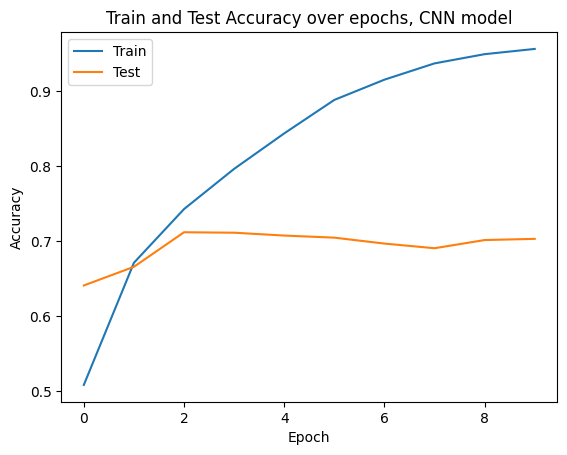

In [11]:
# plot train and test accuracies
plt.plot(range(train_epochs), train_accs, label='Train')
plt.plot(range(train_epochs), test_accs, label='Test')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over epochs, CNN model')
plt.legend()
plt.show()

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 6: Considering the CNN's results


#### **6.1. Reason a bit about why the training and test accuracy look as they do? One question could be: Why is the training accuracy lower than the test accuracy for the first epoch?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

This is really mostly an implementation issue, but a very common one. Basically the training accuracy starts being counted right from the first inference point, meaning that it essentially makes 'blind inference' for the first few tests.

Other than that, they look pretty normal. Test accuracy is as expected, worse than train accuracy, but not by much, so we can't really say it has overfitted in any meaningful way.

</span>

#### **6.2. 💻 Make the network also save the average losses over each epoch as it trains. What does the training loss after each epoch tell you about the state of its training?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

It pretty much just tells us if the network is learning something. That is, does it change its parameters to at least *try* to fit the data better?

If training loss stayed the same across all epochs, something would likely be wrong in our implementation.

</span>


#### **6.3. Can you use the training loss as a measure for the performance of your model?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Hell no. The training loss is only a measure of how well the model is able to fit to the training data. The only real thing it can tell us, is how much our weights are being updated.

We should evaluate performance only on the test set. If we have a validation set, we can use this to test different hyperparameter configurations against each other.

Final model performance should be evaluated **only on on the basis of the test set**, and preferably using a metric that is closer to how the model will be used, as opposed to how it is trained (accuracy as opposed to cross-entropy loss, for example)

</span>


#### **6.4. 💻 Try changing some of the hyperparameters of the network (layers, epochs, learning rate, etc.), are you able to achieve a better test accuracy?**

#### **6.5. 💻 Look into the torch documentatation for [saving and loading models](https://pytorch.org/tutorials/beginner/saving_loading_models.html), try to complete the functions for saving and loading your model resepectively**


</span>




<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

### Defining a FeedForward Neural Network (FFNN)

To have something to compare to our shiny new CNN, it makes sense to implement an FFNN, even though it really isn't meant for image data, it may still perform somewhat.

Here, we don't need to reinvent the wheel, and a lot of boilerplate code is shared between our CNN and FFNN, so we write our FFNN as a *subclass* of the CNN model.

</span>

In [12]:
class FFNN(CNN):
    def __init__(self, in_features, num_classes, lr=0.001):
        # Here, we call the init function of the "grandparent", as we do not necessarily want to call the
        # init function of the CNN (which we would with super().__init__()) (as we don't have channels and whatnot), but torch still requires that we call
        # __init__() for each class that subclasses from torch.nn.module
        nn.Module.__init__(self)
        
        self.num_classes = num_classes

        self.layers = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=num_classes)
        ).to(device)

        # Despite only having linear layers, we still define our loss on the model's ability to find the right class (probabilities)
        self.criterion = nn.CrossEntropyLoss()
        self.optim = torch.optim.Adam(self.layers.parameters(), lr=lr)
            

    def forward(self, x):
        # We flatten images, as we need to treat them as vectors
        x = x.flatten(start_dim=1)
        # Super unecessary, but wanted to show that you can call the parent class' forward function
        return super().forward(x)

100%|██████████| 3125/3125 [00:07<00:00, 395.89it/s]


Epoch 0 validation accuracy: 0.322


100%|██████████| 3125/3125 [00:08<00:00, 386.24it/s]


Epoch 1 validation accuracy: 0.3615


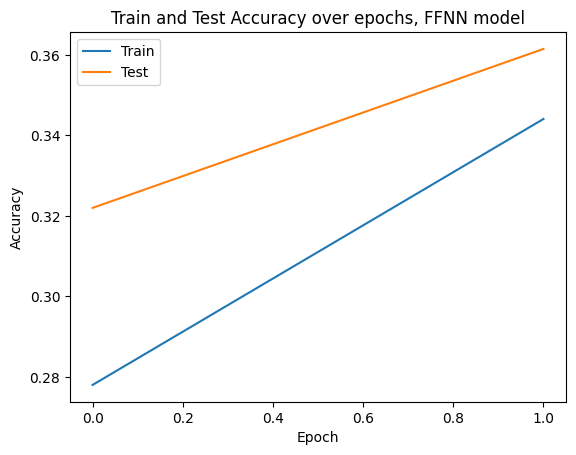

In [13]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Num in_channels really shouldn't be above 1, the FFNN probably can't handle that well
num_in_channels = next(iter(train_dataloader))[0].shape[1]
in_width_height = next(iter(train_dataloader))[0].shape[-1]

FFNN_model = FFNN(in_features=num_in_channels*in_width_height**2,num_classes=10, lr=0.001)

train_epochs = 2
train_accs, test_accs = FFNN_model.train(train_dataloader, epochs=train_epochs, val_dataloader=test_dataloader)

# plot train and test accuracies
plt.plot(range(train_epochs), train_accs, label='Train')
plt.plot(range(train_epochs), test_accs, label='Test')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over epochs, FFNN model')
plt.legend()
plt.show()

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 7: Considering the FFNN's results

#### **7.1. Test the FFNN model for both the CIFAR10 and the MNIST dataset. There should be a *huge* difference in test accuracy when using CIFAR10 compared to MNIST. Explain this gap, and why this gap is comparatively smaller for the CNN model**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

MNIST, in being so simple that it is, doesn't really have much spatial information. How pixels are in realtion to one another does not have as big an effect as in CIFAR10, making the task much more doable for the poor FFNN. The CNN model does not lack spatial awareness, and such does not experience that big a drop in performance from MNIST to CIFAR10, most of it simply being because CIFAR10 is a harder task in general.

</span>

#### **7.2. It should be obvious, that the FFNN model is inferior in terms of test accuracy for this particular task... Does it have any advantages over the CNN?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Two reasons mainly:

- It's faster (normally). This can be especially worthwhile for implementations on mobile phones or other cases where inference time is critical or you have limited resources
- It's easier to explain. People don't really trust models further than they can throw them. Having an easier-to-implement model also reduces the chance of human error in said implentation, which is **very** worthwhile

</span>


#### **7.3. 💻 Try changing the layer structure of your FFNN to see if you can achieve a similar or better test accuracy on CIFAR10 than the CNN. Alternatively, try to see how much you need to hamstring the layers of the CNN to pull it down to the performance level of the FFNN.**


</span>

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 8: Examining the output of the convolutional layers layers

CNN's obviously perform convolutions. We can somewhat examine the form of these convolutions to reason more about what the model "looks for".

The code below grabs the intermediate output after each layer through torch's "forward hoooks", which are functions that can be attached to perform operations during a forward pass. We can try to plot the output after each forward layer to reason about what kind of feature extraction the CNN does.

#### **8.1. Consider the intermediary kernel outputs of both a trained and an untrained CNN model, how do they differ?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">


This is very hard to see in simplistic examples such as this. You should however be able to see the trained model SOMEWHAT focusing better on the cat in the image below... somewhat.

</span>

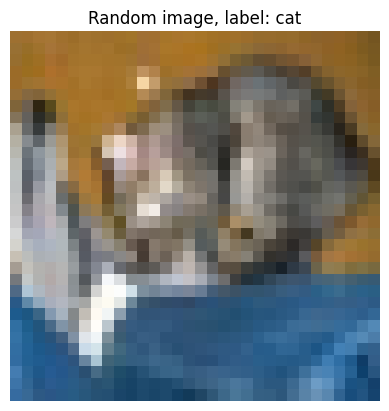

torch.Size([1, 3, 32, 32])
Layer: layers.0, Activation Shape: torch.Size([1, 32, 32, 32])
Layer: layers.3, Activation Shape: torch.Size([1, 64, 14, 14])


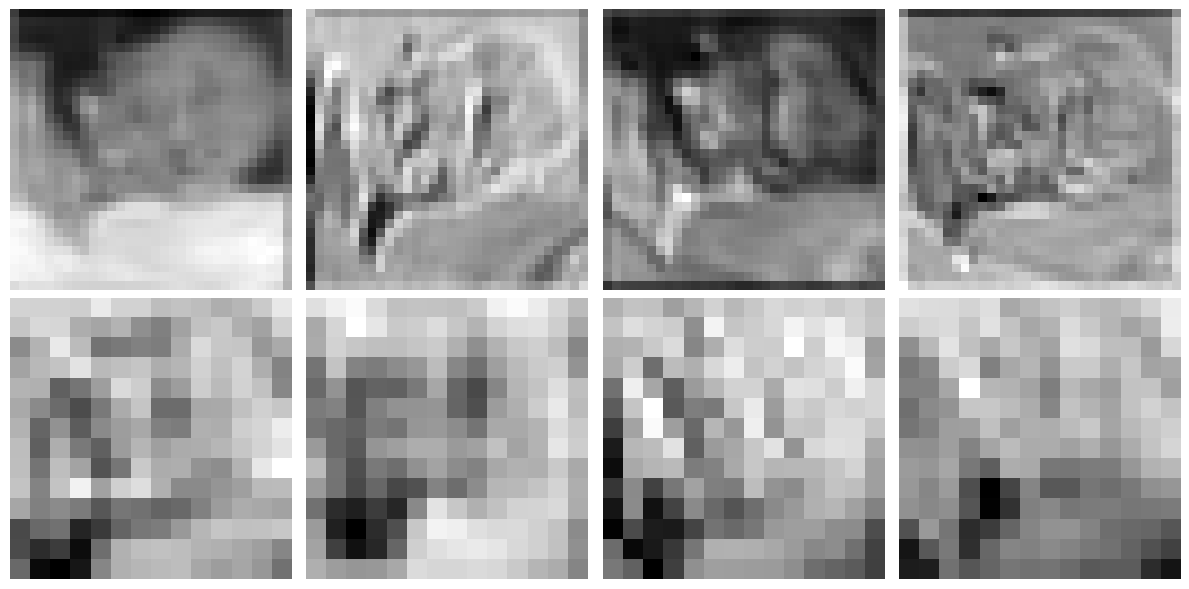

In [14]:
trained_model = True

if trained_model is False:
    # Initialize a dummy untrained CNN model to compare activations with
    in_channels = next(iter(train_dataloader))[0].shape[1]
    in_width_height = next(iter(train_dataloader))[0].shape[-1]
    feats_fore_linear = get_dim_before_first_linear(CNN_model.layers, in_width_height, in_channels, brain=False)
    model = CNN(num_classes=10, in_channels=in_channels, features_fore_linear=feats_fore_linear, lr=0.001) 

else:
    # Otherwise use a trained model
    model = CNN_model

# Dict to hold network activations
activations = {}

# Hook function, is a type of wrapper function that is then called whenever layer registered with it is run
def forward_hook(layer_name, capture_dict):
    def hook(module, input, output):
        capture_dict[layer_name] = output
    return hook

# Register hooks for all Conv2d layers model
for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d):
        layer.register_forward_hook(forward_hook(name, activations))

# Get just a single example from the test dataloader
input_image, input_label = next(iter(test_dataloader))
input_image, input_label = input_image[0].unsqueeze(0).to('cpu'), input_label[0].unsqueeze(0).to('cpu').numpy()[0]

# Plot the image before convolutions
if dataset == 'mnist':
    plt.imshow(input_image.squeeze().numpy(), cmap='gray')
    plt.title(f'Random image, label: {input_label}')

elif dataset == 'cifar10':
    plt.imshow(input_image.squeeze().transpose(0, 2).transpose(0, 1).numpy())
    plt.title(f'Random image, label: {cifar10_classes[input_label]}')
plt.axis('off')  # Hide axis
plt.show()

# Forward pass - Use torch.no_grad() to not store gradients, since we are only interested in activations
with torch.no_grad():
    print(input_image.shape)
    output = model(input_image.to(device))

# Display the captured activations
for layer_name, activation in activations.items():
    print(f"Layer: {layer_name}, Activation Shape: {activation.shape}")

fig, axes = plt.subplots(len(activations.items()), 4, figsize=(12, 6))

for i, (layer_name, activation) in enumerate(activations.items()):
    for j in range(4):
        axes[i, j].imshow(activation[0, j, ...].to('cpu'), cmap='gray')
        axes[i, j].axis('off') 

plt.tight_layout()
plt.show()

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 9: Removed for being weird

(This was an exercise last year, but we removed it for being... a bit strange. Consider it optional if you want, you're not expected to do it)

As mentioned, one reason CNN’s are used for image processing, is because they don’t
explode in parameter complexity as the input image increases in size. Here we will
bastardize the big-O notation from Algorithms and Data structures to denote how the
number of parameters in a nerual network increases as a function of relevant hyperparameters.

#### **9.1. In the aforementioned big-O, how does the number of parameters in a fully connected, feedforward neural network (FFN) grow as a function of image size (assume multiple input channels)? Focus on only the first layer**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

If we denote the size of an image as $N \times N \times C$. A FFNN would require just as many parameters for the first layer, meaning the size of that grows $O(N^2 \cdot C)$, I.E **that's pretty fucking bad, man**. 

Moreover, that is just considering the **first layer**, subsequent layers will need a comparably big or even bigger number of parameters to keep track of these input parameters


</span>

#### **9.2. Again in the Big-O notation, how does the number of parameters in a CNN grow as a function of image size and other relevant layer hyperparameters?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

One of the good things about CNN's, is that the number of parameters do not increase with the size of the image, only the size of the kernel. So with a kernel of size $n \times n$ and d output channels, we $O(n^2 \cdot C \cdot d )$, and given that $n >> N$, it is a much more desirable result, and more importantly, one we can control by changing our parameters.

Keep in mind, this does not necessarily translate to **inference or training time**, as a similar number of numbers need to be multiplied together. But it allows us to get more information with fewer numbers.

</span>